In [1]:
# === Imports ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

# === Paths ===
TRAIN_PATH = "/kaggle/input/processed-traintest/train_processed.csv"
TEST_PATH  = "/kaggle/input/processed-traintest/test_processed.csv"
SAMPLE_PATH = "/kaggle/input/Hotel-Property-Value-Dataset/sample_submission.csv"

# === Load Data ===
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)
sample = pd.read_csv(SAMPLE_PATH)

print("Train:", train.shape, "Test:", test.shape, "Sample:", sample.shape)


Train: (1200, 69) Test: (260, 68) Sample: (3, 2)


Train: (960, 68) | Validation: (240, 68)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


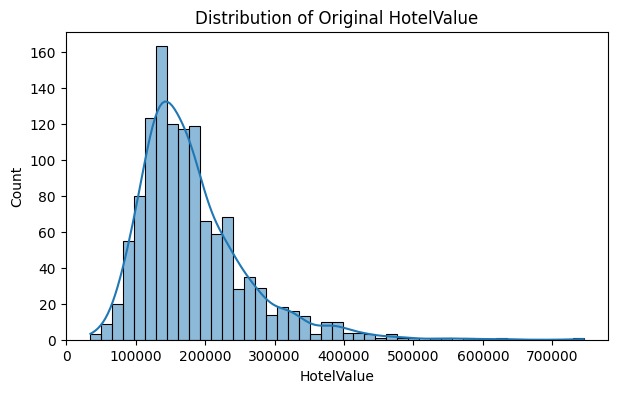

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


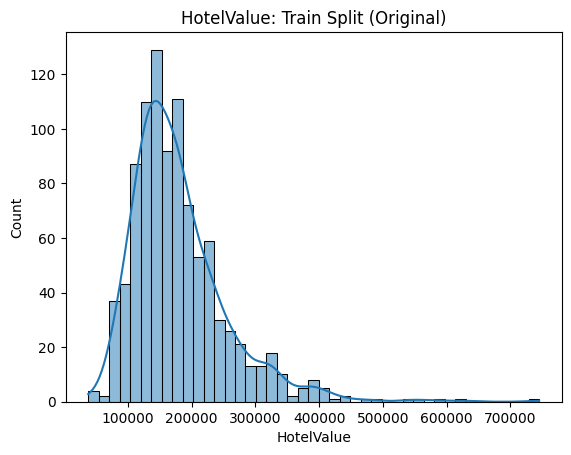

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


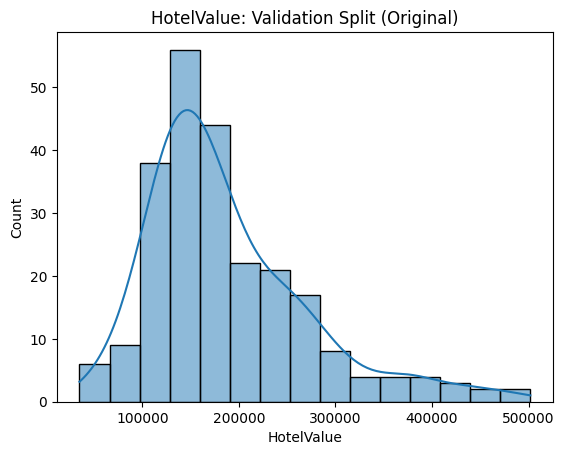

Numeric: 35
Ordinal: ['ExteriorQuality', 'ExteriorCondition', 'BasementHeight', 'BasementCondition', 'BasementExposure', 'HeatingQuality', 'KitchenQuality', 'LoungeQuality', 'ParkingQuality', 'ParkingCondition', 'PoolQuality']
Categorical: ['ZoningCategory', 'RoadType', 'PlotShape', 'LandElevation', 'UtilityAccess', 'PlotConfiguration', 'LandSlope', 'District', 'NearbyTransport1', 'NearbyTransport2', 'PropertyType', 'HotelStyle', 'RoofDesign', 'RoofMaterial', 'ExteriorPrimary', 'ExteriorSecondary', 'FoundationType', 'BasementFacilityType1', 'BasementFacilityType2', 'HeatingType', 'CentralAC', 'ElectricalSystem', 'PropertyFunctionality', 'DrivewayType', 'DealType', 'DealCondition']


In [2]:
# === Split features and target ===
X = train.drop(columns=["HotelValue"])
y = train["HotelValue"]

# Train/Validation Split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train:", X_train.shape, "| Validation:", X_valid.shape)

import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of original target
plt.figure(figsize=(7, 4))
sns.histplot(y, kde=True)
plt.title('Distribution of Original HotelValue')
plt.xlabel('HotelValue')
plt.show()

plt.figure()
sns.histplot(y_train, kde=True)
plt.title('HotelValue: Train Split (Original)')
plt.show()

plt.figure()
sns.histplot(y_valid, kde=True)
plt.title('HotelValue: Validation Split (Original)')
plt.show()


# Apply Log Transformation to Target Variables 
# Create new log-transformed target variables using log1p
y_train_log = np.log1p(y_train)
y_valid_log = np.log1p(y_valid)
# Log-transform the full target variable for final training
y_log = np.log1p(y)

'''
# Identify column types
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numeric:", len(num_cols), "| Categorical:", len(cat_cols))
'''
ordinal_cols = ['ExteriorQuality', 'ExteriorCondition', 'BasementHeight', 'BasementCondition', 
                'BasementExposure', 'HeatingQuality', 'KitchenQuality', 'LoungeQuality',
                'ParkingQuality', 'ParkingCondition', 'PoolQuality']
quality_order = ['Po', 'TA', 'Fa', 'Gd', 'Ex']
exposure_order = ['No', 'Mn', 'Av', 'Gd']

numeric_cols = X.select_dtypes(include=np.number).columns.tolist()

cat_cols = []
ordinal_cat_cols = []
categories_map = []

for c in X.columns:
    if c not in numeric_cols:
        if c in ordinal_cols:
            ordinal_cat_cols.append(c)
            if c == 'BasementExposure':
                categories_map.append(exposure_order)
            else:
                categories_map.append(quality_order)
        else:
            cat_cols.append(c)
            
#cat_cols = [c for c in X.columns if ((c not in numeric_cols) and (c not in ordinal_cols))]

print("Numeric:", len(numeric_cols))
print("Ordinal:", ordinal_cols)
print("Categorical:", cat_cols)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


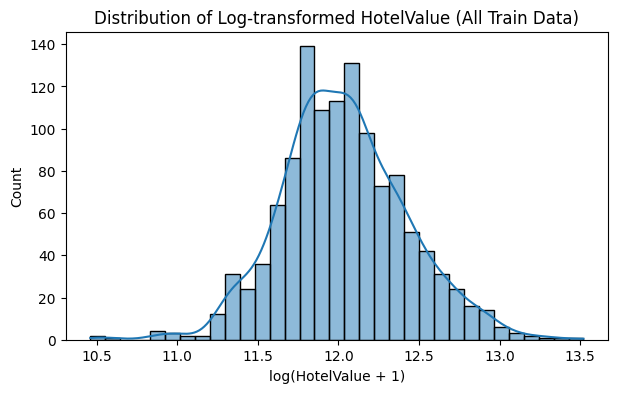

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


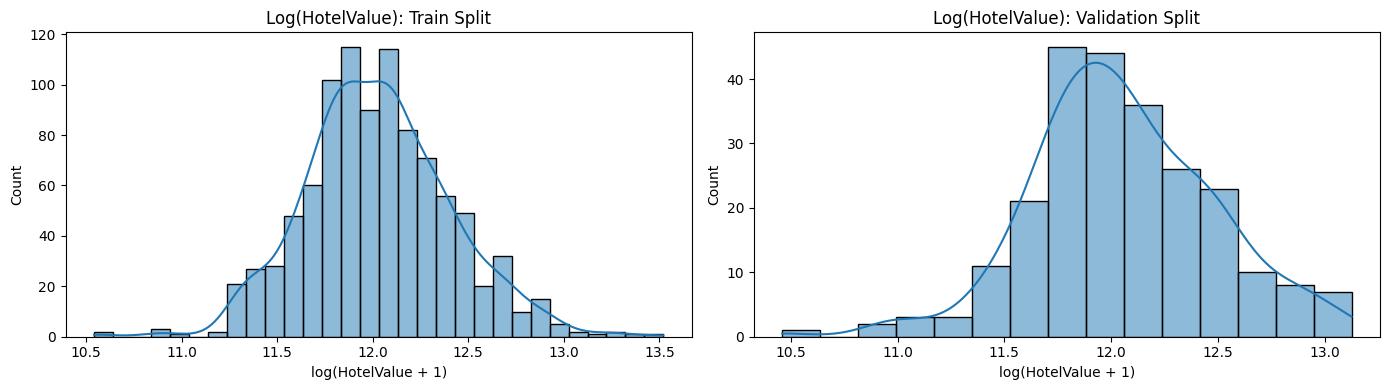

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize log-transformed targets for overall train data
plt.figure(figsize=(7, 4))
sns.histplot(y_log, kde=True)
plt.title('Distribution of Log-transformed HotelValue (All Train Data)')
plt.xlabel('log(HotelValue + 1)')
plt.show()

# Optional: Visualize train/validation splits if you want to inspect data distribution split-wise
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sns.histplot(y_train_log, kde=True, ax=axes[0])
axes[0].set_title('Log(HotelValue): Train Split')
axes[0].set_xlabel('log(HotelValue + 1)')
sns.histplot(y_valid_log, kde=True, ax=axes[1])
axes[1].set_title('Log(HotelValue): Validation Split')
axes[1].set_xlabel('log(HotelValue + 1)')
plt.tight_layout()
plt.show()


In [4]:
# === Preprocessor ===
'''
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        #("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
        ("cat", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1000), cat_cols)
    ]
)
'''

numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

ordinal_encoder = OrdinalEncoder(
    categories = categories_map, handle_unknown='use_encoded_value', 
    unknown_value = -1
)

onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output = False)

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('orde', ordinal_encoder, ordinal_cat_cols),
    ('ohe', onehot_encoder, cat_cols)
])


Ridge Validation RMSE (Original Scale): 24390.4924
Lasso Validation RMSE (Original Scale): 26507.3433
ElasticNet Validation RMSE (Original Scale): 22340.0419


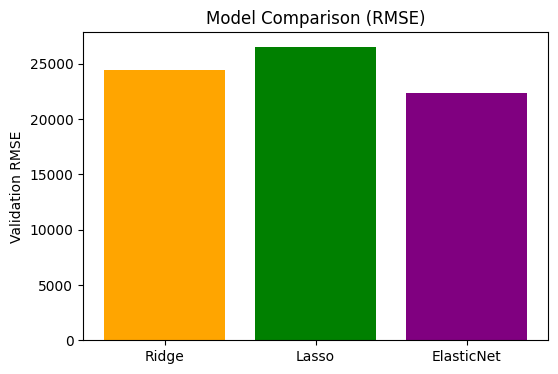

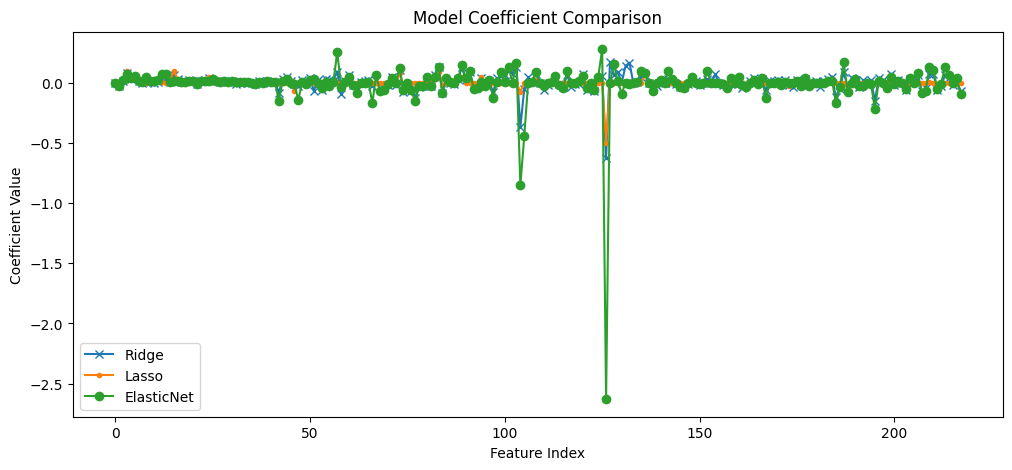

✅ Best model: ElasticNet (RMSE on original scale = 22340.0419)


In [5]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt

# === Define models ===
models = {
    "Ridge": Ridge(alpha=1.0, solver="lsqr"),
    "Lasso": Lasso(alpha=0.001, max_iter=5000),
    "ElasticNet": ElasticNet(alpha=0.00001, l1_ratio=0.98, max_iter=10000)
}

results = {}
pipes = {}

# === Fit each model and store pipes ===
for name, model in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    # Fit using LOG-TRANSFORMED target
    pipe.fit(X_train, y_train_log)
    pipes[name] = pipe
    
    # Predict and inverse transform
    y_pred_log = pipe.predict(X_valid)
    y_pred_original = np.expm1(y_pred_log)
    y_valid_original = np.expm1(y_valid_log)
    # RMSE on original target scale
    rmse = np.sqrt(mean_squared_error(y_valid_original, y_pred_original))
    results[name] = rmse
    print(f"{name} Validation RMSE (Original Scale): {rmse:.4f}")

# === RMSE Bar Chart ===
plt.figure(figsize=(6, 4))
plt.bar(results.keys(), results.values(), color=['orange','green','purple'])
plt.ylabel("Validation RMSE")
plt.title("Model Comparison (RMSE)")
plt.show()

# === Coefficient Visualization ===
coefs_ridge = pipes["Ridge"].named_steps["model"].coef_
coefs_lasso = pipes["Lasso"].named_steps["model"].coef_
coefs_elastic = pipes["ElasticNet"].named_steps["model"].coef_

plt.figure(figsize=(12, 5))
plt.plot(coefs_ridge, label='Ridge', marker='x')
plt.plot(coefs_lasso, label='Lasso', marker='.')
plt.plot(coefs_elastic, label='ElasticNet', marker='o')
plt.legend()
plt.title('Model Coefficient Comparison')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.show()

best_model_name = min(results, key=results.get)
print(f"✅ Best model: {best_model_name} (RMSE on original scale = {results[best_model_name]:.4f})")


Degree 2 → Train RMSE (Original Scale): 25006.25, Valid RMSE (Original Scale): 30501.54
Degree 3 → Train RMSE (Original Scale): 17855.49, Valid RMSE (Original Scale): 60017.03


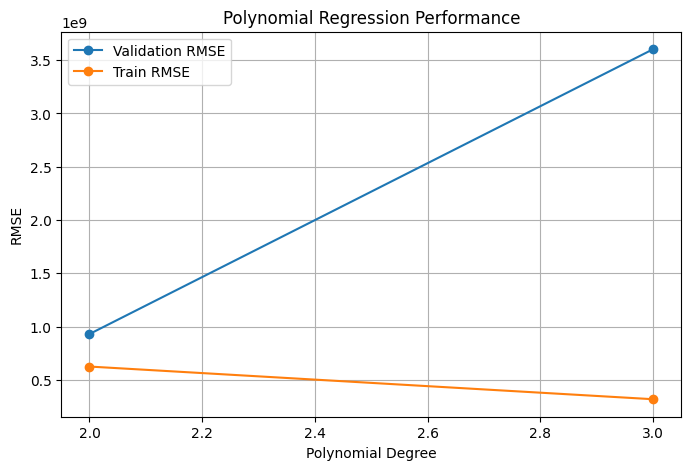

🎯 Best polynomial degree: 2


In [6]:
orders = [2, 3]
#train_errors, valid_errors = [], []
train_errors_original, valid_errors_original = [], []

for degree in orders:
    poly_pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("pca", PCA(n_components=10)),
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
        ("model", LinearRegression())
    ])

    # Fit model using the LOG-TRANSFORMED target
    poly_pipe.fit(X_train, y_train_log)
    
    y_train_pred_log = poly_pipe.predict(X_train)
    y_valid_pred_log = poly_pipe.predict(X_valid)
    
    # Inverse Transform for Evaluation
    y_train_pred_original = np.expm1(y_train_pred_log)
    y_valid_pred_original = np.expm1(y_valid_pred_log)
    
    # Calculate MSE on the ORIGINAL scale
    train_mse = mean_squared_error(np.expm1(y_train_log), y_train_pred_original)
    valid_mse = mean_squared_error(np.expm1(y_valid_log), y_valid_pred_original)
    
    train_errors_original.append(train_mse)
    valid_errors_original.append(valid_mse)
    
    print(f"Degree {degree} → Train RMSE (Original Scale): {np.sqrt(train_mse):.2f}, Valid RMSE (Original Scale): {np.sqrt(valid_mse):.2f}")
    
    '''
    poly_pipe.fit(X_train, y_train)
    y_train_pred = poly_pipe.predict(X_train)
    y_valid_pred = poly_pipe.predict(X_valid)
    
    train_mse = mean_squared_error(y_train, y_train_pred)
    valid_mse = mean_squared_error(y_valid, y_valid_pred)
    train_errors.append(train_mse)
    valid_errors.append(valid_mse)
    
    print(f"Degree {degree} → Train MSE: {train_mse:.2f}, Valid MSE: {valid_mse:.2f}")
    '''

plt.figure(figsize=(8,5))
plt.plot(orders, valid_errors_original, marker='o', label='Validation RMSE')
plt.plot(orders, train_errors_original, marker='o', label='Train RMSE')
plt.legend()
plt.title("Polynomial Regression Performance")
plt.xlabel("Polynomial Degree")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

best_degree = orders[np.argmin(valid_errors_original)]
print(f"🎯 Best polynomial degree: {best_degree}")


In [7]:
# Choose your best model based on RMSE
#if results[best_model_name] < np.sqrt(min(valid_errors)):
if results[best_model_name] < np.sqrt(min(valid_errors_original)):
    final_model = Pipeline([
        ("preprocessor", preprocessor),
        ("model", models[best_model_name])
    ])
    final_model.fit(X, y_log) # Fit on full data, log-transformed target
    test_pred_log = final_model.predict(test)
    test_pred_original = np.expm1(test_pred_log) # Inverse transform final prediction
    submission_name = f"/kaggle/working/{best_model_name}_submission.csv"
    '''
    final_model.fit(X, y)
    test_pred = final_model.predict(test)
    submission_name = f"/kaggle/working/{best_model_name}_submission.csv"
    '''
else:
    final_model = Pipeline([
        ("preprocessor", preprocessor),
        ("pca", PCA(n_components=10)),
        ("poly", PolynomialFeatures(degree=best_degree, include_bias=False)),
        ("model", LinearRegression())
    ])
    final_model.fit(X, y_log) # Fit on full data, log-transformed target
    test_pred_log = final_model.predict(test)
    test_pred_original = np.expm1(test_pred_log) # Inverse transform final prediction
    submission_name = f"/kaggle/working/polynomial_deg{best_degree}_submission.csv"
    '''
    final_model.fit(X, y)
    test_pred = final_model.predict(test)
    submission_name = f"/kaggle/working/polynomial_deg{best_degree}_submission.csv"
    '''

# ✅ Build submission (IDs from processed dataset)
submission = pd.DataFrame({
    "Id": test["Id"].astype(int),
    #"HotelValue": test_pred
    "HotelValue": test_pred_original
})
submission.to_csv(submission_name, index=False)
print(f"✅ Saved submission: {submission_name} | Rows: {len(submission)}")
display(submission.head())


✅ Saved submission: /kaggle/working/ElasticNet_submission.csv | Rows: 260


,Id,HotelValue
0,893,149521.183786
1,1106,335340.377608
2,414,99881.022341
3,523,163913.617493
4,1037,296916.659373
